In [79]:
import numpy as np

def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
        
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    num_test_samples = int(test_size * X.shape[0])
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    return X_train, X_test, y_train, y_test

In [80]:
class LassoReg:
    def __init__(self, alpha=1.0, max_iter=100, tol=0.005):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = None

    def soft_thresholding(self, rho, alpha):
        if rho < -alpha:
            return rho + alpha
        elif rho > alpha:
            return rho - alpha
        else:
            return 0.0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0.0
        Transpose = np.dot(X.T, X)

        for _ in range(self.max_iter):
            prev_coef = np.copy(self.coef_)
            prev_intercept = self.intercept_
            #residuals = y - np.dot(X, self.coef_)
            #self.intercept_ = np.mean(residuals) if n_samples > 1 else residuals[0]
            residuals = y - np.dot(X, self.coef_)
            self.intercept_ = np.mean(residuals)

            for j in range(n_features):
                residuals = y - (np.dot(X, self.coef_) + self.intercept_)
                rho_j = np.dot(X[:, j], residuals + X[:, j] * self.coef_[j])  
                if rho_j < -self.alpha / 2:
                    self.coef_[j] = (rho_j + self.alpha / 2) / Transpose[j, j]
                elif rho_j > self.alpha / 2:
                    self.coef_[j] = (rho_j - self.alpha / 2) / Transpose[j, j]
                else:
                    self.coef_[j] = 0.0

            coef_change = np.max(np.abs(self.coef_ - prev_coef))
            intercept_change = np.abs(self.intercept_ - prev_intercept)
            if coef_change < self.tol and intercept_change < self.tol:
                break

    def predict(self, X):
        return np.dot(X, self.coef_) + self.intercept_

In [82]:
import pandas as pd
file_path = '/Users/ishikamanghwani/desktop/cardetails_csv.csv'
data = pd.read_csv(file_path)
data.head()

,name,year,km_driven,fuel,seller_type,transmission,owner,selling_price
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner,60000
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner,135000
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner,600000
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner,250000
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner,450000


In [83]:
data.columns

Index(['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission',
       'owner', 'selling_price'],
      dtype='object')

In [84]:
data_encoded = pd.get_dummies(data, columns=['fuel', 'seller_type', 'transmission', 'owner'])
X = data_encoded.drop(columns=['selling_price','name'])
y = data_encoded['selling_price']
data_encoded.head()

,name,year,km_driven,selling_price,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,Maruti 800 AC,2007,70000,60000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False
1,Maruti Wagon R LXI Minor,2007,50000,135000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False
2,Hyundai Verna 1.6 SX,2012,100000,600000,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False
3,Datsun RediGO T Option,2017,46000,250000,False,False,False,False,True,False,True,False,False,True,True,False,False,False,False
4,Honda Amaze VX i-DTEC,2014,141000,450000,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False


<Axes: >

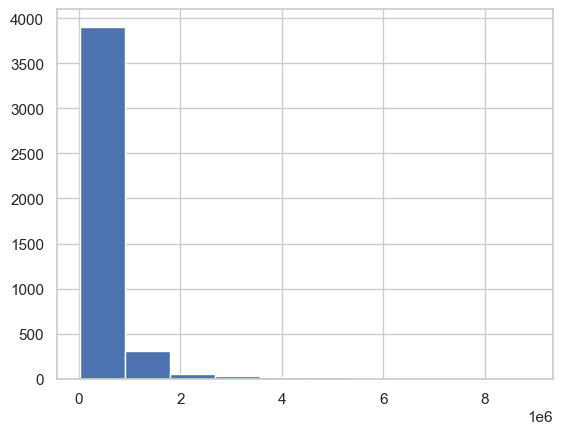

In [85]:
data['selling_price'].hist()

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

X_df = pd.DataFrame(X)
y_df = pd.Series(y)

nan_mask_X = X_df.isna().any(axis=1)
nan_mask_y = y_df.isna()

nan_mask_combined = nan_mask_X | nan_mask_y

X_clean = X_df[~nan_mask_combined]
y_clean = y_df[~nan_mask_combined]

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_mask = isolation_forest.fit_predict(X_clean) != -1

X_clean = X_clean[outlier_mask]
y_clean = y_clean[outlier_mask]

y_clean = y_clean[:X_clean.shape[0]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_df = pd.DataFrame(X_scaled)

print("Original data shape:", X.shape)
print("Cleaned data shape:", X_clean.shape)
print("Scaled data shape:", X_scaled_df.shape)
print("Scaled feature shape", y_clean.shape)

Original data shape: (4340, 17)
Cleaned data shape: (3906, 17)
Scaled data shape: (3906, 17)
Scaled feature shape (3906,)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_clean, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Testing target shape:", y_test.shape)
from sklearn.metrics import mean_squared_error

Training data shape: (2500, 17)
Validation data shape: (625, 17)
Testing data shape: (781, 17)
Training target shape: (2500,)
Validation target shape: (625,)
Testing target shape: (781,)


In [88]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

lasso_model = LassoReg(alpha=0.001)
lasso_model.fit(X_train_np, y_train_np)

predictions = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Custom Lasso Regression Mean Squared Error:", mse)

Custom Lasso Regression Mean Squared Error: 125620152582.40373


In [89]:
"""
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  
])

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['mean_squared_error'])

history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=(X_val, y_val))

test_loss, test_mse = model.evaluate(X_test, y_test)
print(f'Test MSE for TensorFlow Model: {test_mse}')
"""
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Initialize the Lasso regression model
model = Lasso(alpha=0.1, max_iter=1000)

# Fit the Lasso model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Calculate the mean squared error for the validation and test sets
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Validation MSE for Lasso Model: {val_mse}')
print(f'Test MSE for Lasso Model: {test_mse}')

Validation MSE for Lasso Model: 73903989209.6155
Test MSE for Lasso Model: 125620153695.85683


/Users/ishikamanghwani/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.818e+12, tolerance: 5.522e+10
  model = cd_fast.enet_coordinate_descent(


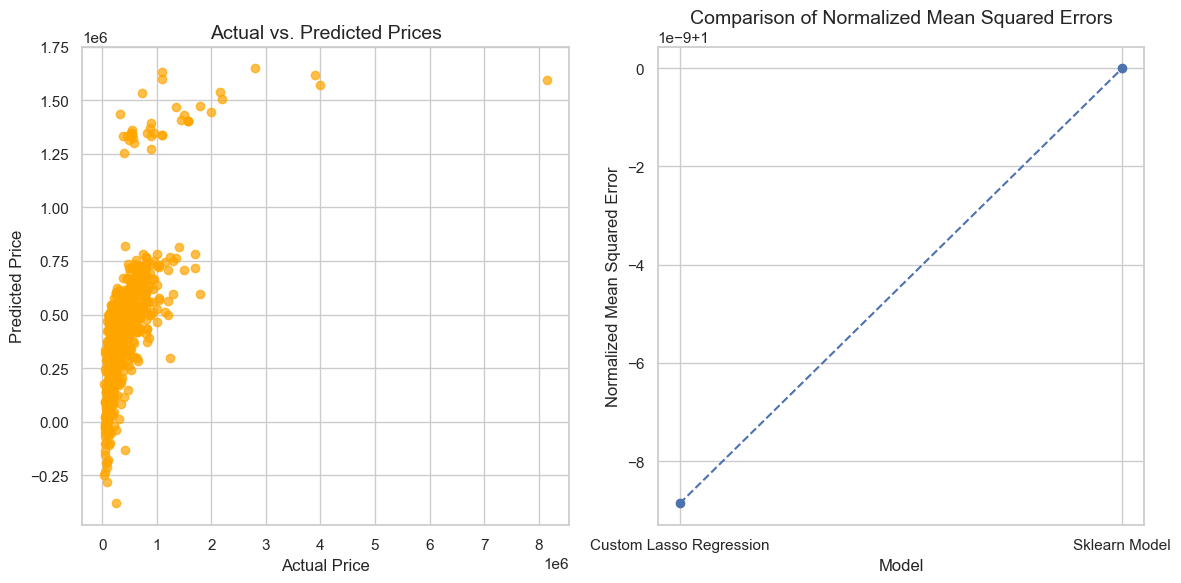

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
max_mse = max(mse, test_mse)
normalized_mse_custom = mse / max_mse
normalized_mse_skl = test_mse / max_mse

#prices
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions, color='orange', alpha=0.7)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Predicted Price', fontsize=12)
plt.title('Actual vs. Predicted Prices', fontsize=14)

#mse
plt.subplot(1, 2, 2)
plt.plot(['Custom Lasso Regression', 'Sklearn Model'], [normalized_mse_custom, normalized_mse_skl], marker='o', linestyle='--')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Normalized Mean Squared Error', fontsize=12)
plt.title('Comparison of Normalized Mean Squared Errors', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()

In [91]:
print('Custom Lasso Coefficients:', lasso_model.coef_)
print('Sklearn Lasso Coefficients:', model.coef_)

Custom Lasso Coefficients: [ 1.35218162e+05 -3.37444085e+04 -1.53267903e+03  1.22164411e+05
  0.00000000e+00 -1.26376589e+03 -7.61732524e+02  4.13008864e+03
 -4.71424962e+02  2.09622150e+03  2.02300281e+05 -6.62740116e-09
  1.89390531e+04 -5.56367815e+03  1.21574623e+03  0.00000000e+00
 -2.25547065e+02]
Sklearn Lasso Coefficients: [ 1.35218116e+05 -3.37442836e+04 -1.52972062e+03  1.22189276e+05
  0.00000000e+00 -1.26022782e+03 -7.36746681e+02  4.10899988e+03
 -4.92787063e+02  2.09120950e+03  2.02300215e+05 -8.16562279e-09
  1.88301952e+04 -5.58676077e+03  1.11526936e+03  0.00000000e+00
 -2.83460162e+02]
